# Lab 3: Stochastic Gradient Descent

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD3"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L3_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from tqdm import tqdm

We import the dataset that we are going to use, an indian dataset including in the last column information about the diabetes status of patients:

In [2]:
from sklearn import model_selection

data = pd.read_csv("w8a.csv", sep=";", header=None)

X = data.iloc[:,:-1].to_numpy()
y = data.iloc[:,-1].to_numpy()
y = ((y+2)/2).astype(int)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=32)

## Logistic Regression



Today we'll be moving from linear regression to logistic regression, one of the simplest ways to deal with a classification problem. Instead of fitting a line, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$f(z) = \frac{1}{1+\exp{-z}}.$$

To predict the class of our observations we'll have to minimize the corresponding loss function and as we are in a high-dimensional context we'll add an $l_2$ regularization to the model:

$$L(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label.  


We first use the `sklearn` implementation:

0.9716480153610753


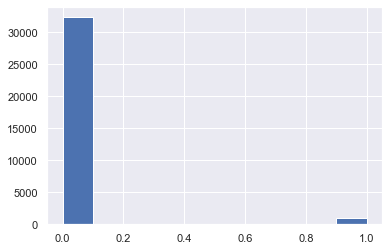

In [3]:
print(np.mean(y_train == 0))
plt.hist(y_train)
plt.show()

In [4]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=32, max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

and we compute the accuracy score to evaluate the model performance:

In [5]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9837


### Assignment

Implement from scratch your own logistic regression model with stochastic gradient descent optimization. 

- Fill in the class

- Display the evolution of the cost function along iterations. Do this for several strategies for the setting of the learning rate

- Try the different acceleration strategies

- Train the model with the training set and evaluate its performance in the test set

In [26]:
from sklearn.utils import shuffle

class StochasticLogisticRegression():
    
    """ Class for logistic regression:
    
    Attributes:                                                                                 
    -----------                                                                              Default value
    coef_         : 1-dimensional np.array, coefficients / weights                         | None                
    lambd_        : float,                  regularization parameter                       | 0.1
    lr_           : float,                  the learning rate                              | 0.01
    bsize         : integer,                the size of the mini-batch >=1                 | 64
    gamma         : float,                  gamma coefficient                              | 0.999
    beta          : float,                  beta coefficient                               | 0.9
    eps           : float,                  epsilon coefficient                            | 10-8
    debias        : boolean,                indicates if we use the debiais correction     | False
    coef_history_ : list,                   the list of all visited betas/ weights         | []
    f_history_    : list ,                  the list of all evaluations in visited betas   | []
    thresh        : float,                  decision threshold for classification          | 0.5
    """
    
    def __init__(self, lambd=0.1, lr=1e-2, batchsize=64, gamma=0.999, beta=0.9, eps=1e-8, debias=False,
                 thresh=0.5):
        self.coef_         = None # weights
        self.lambd_        = lambd
        self.lr_           = lr
        self.bsize_        = batchsize
        self.gamma_        = gamma
        self.beta_         = beta
        self.eps_          = eps
        self.debias_       = debias
        self.coef_history_ = []
        self.f_history_    = []
        self.thresh_       = thresh

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def loss(self, X, y):
        y_proba = self.sigmoid(X.dot(self.coef_)).flatten()
        loss = -np.mean((y*np.log(y_proba + self.eps_) + (1 - y) * np.log(1 - y_proba + self.eps_))) #+ np.linalg.norm(self.coef_, 2)
        # print(np.linalg.norm(self.coef_, 2))
        # print(np.log(z), np.log(1-z), z)
        return loss
        
    def fit(self, X, y, lr=1e-2, bsize=None, max_iter=100, minibatch=False):
        
        """ Fit the data (X, y).
    
        Parameters:
        -----------                                                                         Default value
        X          : (num_samples, num_features) np.array, Design matrix                  | 
        y          : (num_sampes, ) np.array,              Output vector                  | 
        lr         : float,                                the learning rate              | 0.001
        bsize      : integer,                              the size of the mini-batch >=1 | 64
        max_iter   : integer,                              the number of epochs           | 100
        mini_batch : bool,                                 method used                    | False
        """
        n_samples, n_features = X.shape
        self.coef_ = np.random.rand(n_features+1).reshape(-1, 1)
        self.coef_[:, -1] = 0
        m = np.zeros_like(self.coef_)
        v = np.zeros_like(self.coef_)
        t = 0
        X_aug = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)

        if not minibatch:
            self.bsize_ = 1
        elif bsize is not None:
            self.bsize_ = bsize

        pbar = tqdm(range(max_iter))
        for epoch in pbar:
            X_aug, y = shuffle(X_aug, y)
            for i in range(0, n_samples, self.bsize_):
                
                X_batch = X_aug[i:i+self.bsize_, :]
                y_batch = y[i:i+self.bsize_]
                
                y_proba = self.sigmoid(X_batch.dot(self.coef_))
                grad = -np.mean(X_batch.T.dot(y_batch - y_proba), axis=1, keepdims=True) + self.lambd_ * self.coef_
    
                t += 1
                m = self.beta_ * m + (1 - self.beta_) * grad
                v = self.gamma_ * v + (1 - self.gamma_) * (grad ** 2)
                
                if self.debias_:
                    m_hat = m / (1 - self.beta_ ** t)
                    v_hat = v / (1 - self.gamma_ ** t)
                else:
                    m_hat, v_hat = m, v
                
                self.coef_ -= lr * m_hat / (np.sqrt(v_hat) + self.eps_)
            
            self.coef_history_.append(self.coef_.copy())
            self.f_history_.append(self.loss(X_aug, y))
            pbar.set_postfix({"loss": self.f_history_[-1]})


    def predict(self, X):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array, Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array, Predictions (0 or 1)
        """
        X_aug = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
        probas = self.sigmoid(X_aug.dot(self.coef_))
        return (probas >= self.thresh_).astype(int)
    
    def accuracy_evaluation(self,X,y,thresh=0.5,margin=0, vizualisation=False):
        """ Compute detailed accuracy rates.
    
        Parameters:
        -----------                                                              Default value
        X                : (num_samples, num_features) np.array, Input data    | 
        y                : (num_samples, ) np.array, Labels of the input data  | 
        thresh           : Decision threshold                                  | 0.5
        margin           : If the prediction is at a distance less than margin | 0
                           to the treshold, returns undetermined label.        |
        vizualisation    : Allow the user to vizualize in a board the results  | True
            
        Returns:
        -----
        good_prediction  : % of correct classifications
        undetermined     : % of indetermined labels 
        wrong_prediction : % of wrong classifications
        TP               : % of 1 labelled 1
        UP               : % of 1 labelled undetermined
        FN               : % of 1 labelled 0
        TN               : % of 0 labelled 0
        UN               : % of 0 labelled undetermined
        FP               : % of 0 labelled 1
        F1_score         : F1-score
        """ 
        X_aug = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
        probas = self.sigmoid(X_aug.dot(self.coef_)).flatten()
        
        y_pred = np.zeros_like(y)
        y_pred[probas > thresh + margin] = 1
        y_pred[probas < thresh - margin] = 0
        y_pred[(probas >= thresh - margin) & (probas <= thresh + margin)] = -1  # Undetermined

        TP = np.sum((y == 1) & (y_pred == 1)) / np.sum(y == 1)
        UP = np.sum((y == 1) & (y_pred == -1)) / np.sum(y == 1)
        FN = np.sum((y == 1) & (y_pred == 0)) / np.sum(y == 1)
        TN = np.sum((y == 0) & (y_pred == 0)) / np.sum(y == 0)
        UN = np.sum((y == 0) & (y_pred == -1)) / np.sum(y == 0)
        FP = np.sum((y == 0) & (y_pred == 1)) / np.sum(y == 0)

        good_prediction = np.mean(y == y_pred)
        undetermined = np.mean(y_pred == -1)
        wrong_prediction = np.mean((y != y_pred) & (y_pred != -1))

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        F1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        if vizualisation:
            print(f"Good predictions: {good_prediction:.2%}")
            print(f"Undetermined: {undetermined:.2%}")
            print(f"Wrong predictions: {wrong_prediction:.2%}")
            print(f"True Positives: {TP:.2%}")
            print(f"Undetermined Positives: {UP:.2%}")
            print(f"False Negatives: {FN:.2%}")
            print(f"True Negatives: {TN:.2%}")
            print(f"Undetermined Negatives: {UN:.2%}")
            print(f"False Positives: {FP:.2%}")
            print(f"F1-score: {F1_score:.4f}")

        return good_prediction, undetermined, wrong_prediction, TP, UP, FN, TN, UN, FP, F1_score

    
    def find_thresh(self, X, y, step=0.01,margin=0):
        """Find the decision threshsold that maximize the f1_score
        
        Parameters:
        -----------                                                    Default value
        X      : (num_samples, num_features) np.array, Input data    | 
        y      : (num_samples, ) np.array, Labels of the input data  | 
        step   : Decision threshold                                  | 0.5
        margin : If the prediction is at a distance less than margin | 0
                 to the treshold, returns undetermined label.        |
        """  
        best_thresh = 0
        best_f1 = 0
        for thresh in np.arange(0, 1 + step, step):
            _, _, _, _, _, _, _, _, _, f1_score = self.accuracy_evaluation(X, y, thresh, margin)
            if f1_score > best_f1:
                best_f1 = f1_score
                best_thresh = thresh
        self.thresh_ = best_thresh
        return best_thresh, best_f1

Apply to the data

On essaie plusieurs entraînements avec différents coefficients de régularisation, on choisit celui qui minimise
l'erreur sur le test set. On entraine sur 1000 itérations en batch gradient descent. On garde **lambda = 2**.
On essaie ensuite plusieurs learning rates, on choisit le plus grand qui permet d'obtenir un gradient qui converge. On garde **lr = 0.01**.

## Optimal threshold

100%|██████████| 100/100 [00:16<00:00,  6.23it/s, loss=0.126]


Accuracy: 0.9675


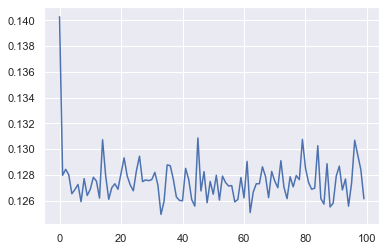

In [28]:
model = StochasticLogisticRegression(2, 0.001, 512)
model.fit(X_train, y_train, max_iter=100, minibatch=True)


# Make predictions on the test set
y_pred = model.predict(X_test)

# model.accuracy_evaluation(X_test, y_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

plt.plot(model.f_history_)

## Training of the model

Best threshold : 0.03
Accuracy: 0.9675
(0.3342672676330856, 0.0, 0.6657327323669143, 0.9082397003745318, 0.0, 0.09176029962546817, 0.31497104004029214, 0.0, 0.6850289599597079, 0.7004593964880377)


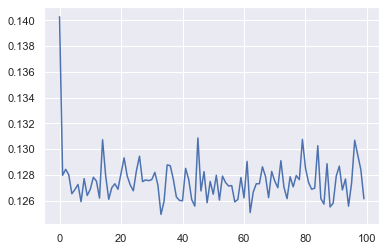

In [30]:
best_th,_=model.find_thresh(X_test,y_test)

print("Best threshold :", best_th)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")

print(model.accuracy_evaluation(X_test, y_test,best_th ))

Implement only one acceleration method and compare the results

## Study of the batchsize impact

In [53]:
models_1 = {}
for bs in [1, 16, 32,64,128,256,512,1024, 2048, 4096]:
    model = StochasticLogisticRegression(2, 0.001, bs)
    model.fit(X_train, y_train, max_iter=100, minibatch=True)
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    best_th,_=model.find_thresh(X_test,y_test)
    print(f"Best threshold: {best_th} for bs: {bs}")

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy (sklearn): {accuracy} for bs: {bs}")

    a = model.accuracy_evaluation(X_test, y_test,best_th )
    print(f"Accuracy: {a[0]:.2%} for bs: {bs}")
    print(f"F1-score: {a[-1]}")

    models_1[str(bs)]= {
        "accuracy":a[0],
        "sklearn_accuracy": accuracy,
        "loss": model.f_history_,
        "f1": a[-1]
    }

100%|██████████| 100/100 [01:32<00:00,  1.09it/s, loss=0.502]


Best threshold: 0.37 for bs: 1
Accuracy (sklearn): 0.9669874527957121 for bs: 1
Accuracy: 37.77% for bs: 1
F1-score: 0.7034436282919174


100%|██████████| 100/100 [00:11<00:00,  9.04it/s, loss=0.226]


Best threshold: 0.14 for bs: 16
Accuracy (sklearn): 0.967474722865148 for bs: 16
Accuracy: 36.61% for bs: 16
F1-score: 0.7001148129276777


100%|██████████| 100/100 [00:14<00:00,  6.98it/s, loss=0.17]


Best threshold: 0.08 for bs: 32
Accuracy (sklearn): 0.967474722865148 for bs: 32
Accuracy: 37.04% for bs: 32
F1-score: 0.7079028922993051


100%|██████████| 100/100 [00:14<00:00,  6.96it/s, loss=0.151]


Best threshold: 0.06 for bs: 64
Accuracy (sklearn): 0.967474722865148 for bs: 64
Accuracy: 31.91% for bs: 64
F1-score: 0.7035592994965086


100%|██████████| 100/100 [00:10<00:00,  9.84it/s, loss=0.132]


Best threshold: 0.03 for bs: 128
Accuracy (sklearn): 0.967474722865148 for bs: 128
Accuracy: 29.03% for bs: 128
F1-score: 0.7010648050894118


100%|██████████| 100/100 [00:09<00:00, 10.19it/s, loss=0.128]


Best threshold: 0.04 for bs: 256
Accuracy (sklearn): 0.967474722865148 for bs: 256
Accuracy: 43.58% for bs: 256
F1-score: 0.7041520925590576


100%|██████████| 100/100 [00:15<00:00,  6.66it/s, loss=0.128]


Best threshold: 0.03 for bs: 512
Accuracy (sklearn): 0.967474722865148 for bs: 512
Accuracy: 22.32% for bs: 512
F1-score: 0.686815448776938


100%|██████████| 100/100 [00:21<00:00,  4.76it/s, loss=0.128]


Best threshold: 0.03 for bs: 1024
Accuracy (sklearn): 0.967474722865148 for bs: 1024
Accuracy: 26.50% for bs: 1024
F1-score: 0.6798207861103387


100%|██████████| 100/100 [00:35<00:00,  2.82it/s, loss=0.127]


Best threshold: 0.02 for bs: 2048
Accuracy (sklearn): 0.967474722865148 for bs: 2048
Accuracy: 8.14% for bs: 2048
F1-score: 0.6731249080515649


100%|██████████| 100/100 [01:02<00:00,  1.60it/s, loss=0.128]


Best threshold: 0.03 for bs: 4096
Accuracy (sklearn): 0.967474722865148 for bs: 4096
Accuracy: 44.68% for bs: 4096
F1-score: 0.6742315256746709


Text(0.5, 1.0, 'Accuracy')

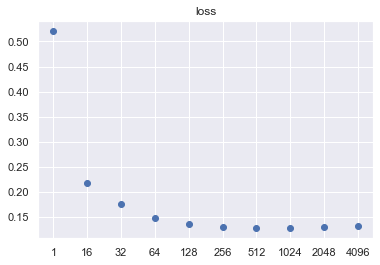

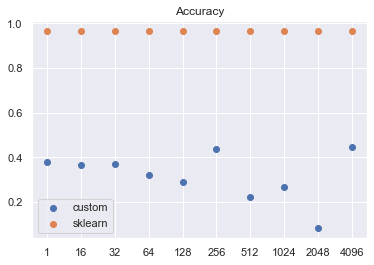

In [63]:
losses=[]
accuracies = []
accuracies_sk = []
bs_ = []
for bs, data in models_1.items():
    accuracies.append(data["accuracy"])
    accuracies_sk.append(data['sklearn_accuracy'])
    losses.append(np.mean(data["loss"][:-10]))
    bs_.append(str(bs))

plt.figure()
plt.scatter(bs_, losses)
plt.title("loss")

plt.figure()
plt.scatter(bs_, accuracies, label="custom")
plt.scatter(bs_, accuracies_sk, label="sklearn")
plt.legend()
plt.title("Accuracy")

The best batch size is 256

## Gamma impact

In [55]:
models_2 = {}
for gamma in [0.000001,0.001,0.1,0.5,0.9,0.99,0.999]:
    model = StochasticLogisticRegression(2, 0.001, 512, gamma=gamma)
    model.fit(X_train, y_train, max_iter=100, minibatch=True)
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    best_th,_=model.find_thresh(X_test,y_test)
    print(f"Best threshold: {best_th} for gamma: {gamma}")

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy (sklearn): {a[0]:.2%} for gamma: {gamma}")

    a = model.accuracy_evaluation(X_test, y_test,best_th )
    print(f"Accuracy: {a[0]:.2%} for gamma: {gamma}")
    print(f"F1-score: {a[-1]}")

    models_2[str(gamma)]= {
        "accuracy":a[0],
        "sklearn_accuracy": accuracy,
        "loss": model.f_history_,
        "f1": a[-1]
    }

100%|██████████| 100/100 [00:14<00:00,  6.85it/s, loss=0.47]


Best threshold: 0.0 for gamma: 1e-06
Accuracy (sklearn): 44.68% for gamma: 1e-06
Accuracy: 3.25% for gamma: 1e-06
F1-score: 0.6666666666666666


100%|██████████| 100/100 [00:13<00:00,  7.22it/s, loss=0.139]


Best threshold: 0.03 for gamma: 0.001
Accuracy (sklearn): 3.25% for gamma: 0.001
Accuracy: 13.00% for gamma: 0.001
F1-score: 0.6814603226483107


100%|██████████| 100/100 [00:13<00:00,  7.24it/s, loss=0.132]


Best threshold: 0.05 for gamma: 0.1
Accuracy (sklearn): 13.00% for gamma: 0.1
Accuracy: 51.02% for gamma: 0.1
F1-score: 0.6903340129859724


100%|██████████| 100/100 [00:13<00:00,  7.25it/s, loss=0.126]


Best threshold: 0.03 for gamma: 0.5
Accuracy (sklearn): 51.02% for gamma: 0.5
Accuracy: 32.03% for gamma: 0.5
F1-score: 0.6993382741355814


100%|██████████| 100/100 [00:14<00:00,  7.13it/s, loss=0.129]


Best threshold: 0.04 for gamma: 0.9
Accuracy (sklearn): 32.03% for gamma: 0.9
Accuracy: 45.12% for gamma: 0.9
F1-score: 0.682747207874546


100%|██████████| 100/100 [00:14<00:00,  7.09it/s, loss=0.126]


Best threshold: 0.03 for gamma: 0.99
Accuracy (sklearn): 45.12% for gamma: 0.99
Accuracy: 39.04% for gamma: 0.99
F1-score: 0.6956812434510511


100%|██████████| 100/100 [00:14<00:00,  7.14it/s, loss=0.126]


Best threshold: 0.03 for gamma: 0.999
Accuracy (sklearn): 39.04% for gamma: 0.999
Accuracy: 32.64% for gamma: 0.999
F1-score: 0.7001102182589425


Text(0.5, 1.0, 'F1-score')

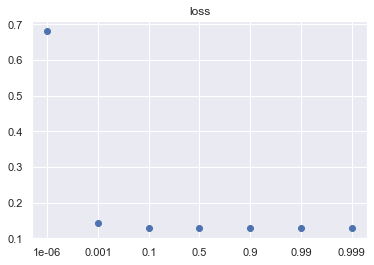

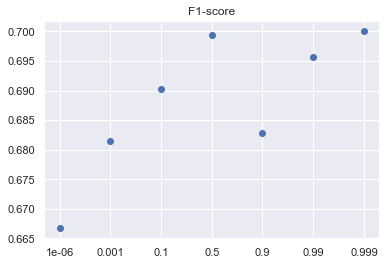

In [60]:
losses=[]
f1 = []
bs_ = []
for bs, data in models_2.items():
    f1.append(data["f1"])
    losses.append(np.mean(data["loss"][:-10]))
    bs_.append(str(bs))

plt.figure()
plt.scatter(bs_, losses)
plt.title("loss")

plt.figure()
plt.scatter(bs_, f1)
plt.title("F1-score")

The best gamma is 0.999

## Beta impact
Nous allons comparer les paramètres beta pour gamma = 0.999 et batch_size=1024

In [61]:
models_3 = {}
for beta in [0.000001,0.001,0.1,0.5,0.9,0.99,0.999]:
    model = StochasticLogisticRegression(2, 0.001, 1024, beta=beta)
    model.fit(X_train, y_train, max_iter=100, minibatch=True)
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    best_th,_=model.find_thresh(X_test,y_test)
    print(f"Best threshold: {best_th} for beta: {beta}")

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy (sklearn): {a[0]:.2%} for beta: {beta}")

    a = model.accuracy_evaluation(X_test, y_test,best_th )
    print(f"Accuracy: {a[0]:.2%} for beta: {beta}")
    print(f"F1-score: {a[-1]}")

    models_3[str(beta)]= {
        "accuracy":a[0],
        "sklearn_accuracy": accuracy,
        "loss": model.f_history_,
        "f1": a[-1]
    }

100%|██████████| 100/100 [00:21<00:00,  4.57it/s, loss=0.129]


Best threshold: 0.03 for beta: 1e-06
Accuracy (sklearn): 26.05% for beta: 1e-06
Accuracy: 9.64% for beta: 1e-06
F1-score: 0.6716572861683823


100%|██████████| 100/100 [00:21<00:00,  4.55it/s, loss=0.128]


Best threshold: 0.03 for beta: 0.001
Accuracy (sklearn): 9.64% for beta: 0.001
Accuracy: 20.92% for beta: 0.001
F1-score: 0.6841024633986961


100%|██████████| 100/100 [00:21<00:00,  4.55it/s, loss=0.127]


Best threshold: 0.03 for beta: 0.1
Accuracy (sklearn): 20.92% for beta: 0.1
Accuracy: 38.99% for beta: 0.1
F1-score: 0.682886535533115


100%|██████████| 100/100 [00:22<00:00,  4.53it/s, loss=0.128]


Best threshold: 0.03 for beta: 0.5
Accuracy (sklearn): 38.99% for beta: 0.5
Accuracy: 16.08% for beta: 0.5
F1-score: 0.6831271577972602


100%|██████████| 100/100 [00:22<00:00,  4.51it/s, loss=0.128]


Best threshold: 0.03 for beta: 0.9
Accuracy (sklearn): 16.08% for beta: 0.9
Accuracy: 13.50% for beta: 0.9
F1-score: 0.6776194352029368


100%|██████████| 100/100 [00:21<00:00,  4.64it/s, loss=0.127]


Best threshold: 0.03 for beta: 0.99
Accuracy (sklearn): 13.50% for beta: 0.99
Accuracy: 30.90% for beta: 0.99
F1-score: 0.6907144274204702


100%|██████████| 100/100 [00:23<00:00,  4.32it/s, loss=0.13]


Best threshold: 0.01 for beta: 0.999
Accuracy (sklearn): 30.90% for beta: 0.999
Accuracy: 25.89% for beta: 0.999
F1-score: 0.6772875264816733


Text(0.5, 1.0, 'F1-score')

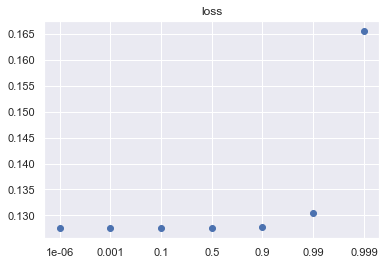

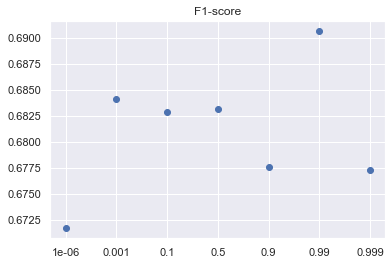

In [62]:
losses=[]
f1 = []
bs_ = []
for bs, data in models_3.items():
    f1.append(data["f1"])
    losses.append(np.mean(data["loss"][:-10]))
    bs_.append(str(bs))

plt.figure()
plt.scatter(bs_, losses)
plt.title("loss")

plt.figure()
plt.scatter(bs_, f1)
plt.title("F1-score")

The best beta is 0.9